In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from IPython.display import HTML
from celluloid import Camera

from thor_magni_tools.utils.load import load_csv_metadata_magni, preprocessing_header_magni
from thor_magni_tools.preprocessing.filtering import Filterer3DOF
from thor_magni_tools.preprocessing import TrajectoriesReprocessor
from thor_magni_tools.utils.visualization_nb import visualize_scenario

In [2]:
DIR_PATH = "../datasets/thor_magni_zenodo/"
SCENARIO_ID = "Scenario_1"

In [3]:
raw_df, header_dict = load_csv_metadata_magni(
    os.path.join(DIR_PATH, SCENARIO_ID, "THOR-Magni_130522_SC1B_R1.csv")
)

In [4]:
new_header_dict = preprocessing_header_magni(header_dict)
traj_metadata = new_header_dict["SENSOR_DATA"]["TRAJECTORIES"]["METADATA"]

### Filtering best markers

In [5]:
roles = {k: metadata["ROLE"] for k, metadata in traj_metadata.items()}
best_markers_traj = Filterer3DOF.filter_best_markers(raw_df, roles)

In [6]:
restored_markers = Filterer3DOF.restore_markers(raw_df, roles)

### Visualization

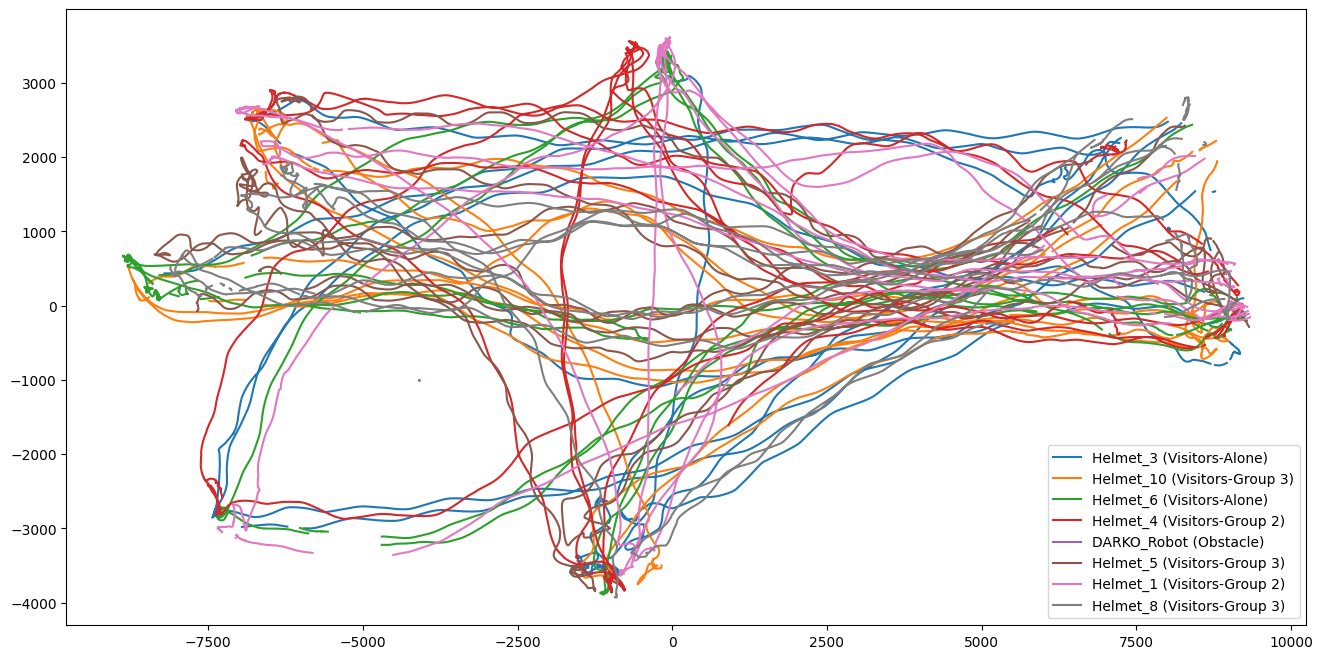

In [7]:
visualize_scenario(best_markers_traj, roles)

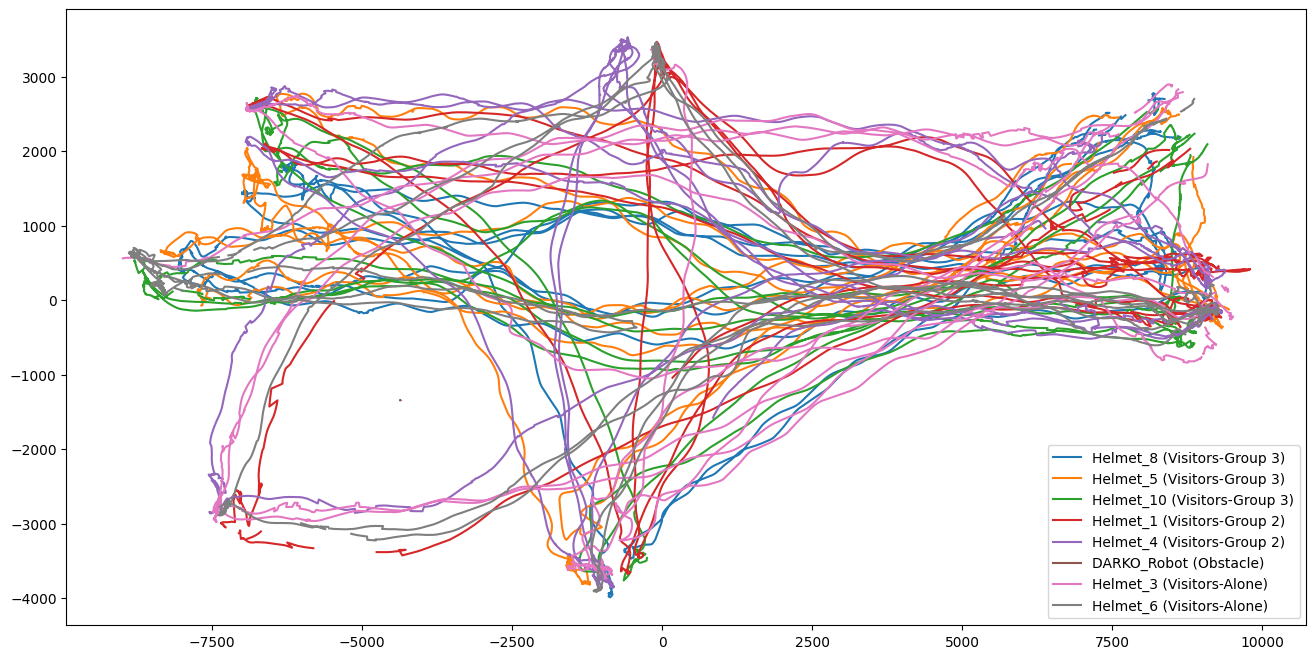

In [8]:
visualize_scenario(restored_markers, roles)

## Preprocessing

In [9]:
pp_best_markers = TrajectoriesReprocessor.reprocessing(
    best_markers_traj, 
    max_nans_interpolate=100, # max  1s interpolation
    resampling_rule="400ms",
    average_window="800ms",
)  

2023-11-02 14:11:15,084 - thor_magni_tools.preprocessing.reprocess - DEBUG - resampling applied! (reprocess.py:101)
2023-11-02 14:11:15,084 - thor_magni_tools.preprocessing.reprocess - DEBUG - resampling applied! (reprocess.py:101)
2023-11-02 14:11:15,089 - thor_magni_tools.preprocessing.reprocess - DEBUG - average window applied! (reprocess.py:108)
2023-11-02 14:11:15,089 - thor_magni_tools.preprocessing.reprocess - DEBUG - average window applied! (reprocess.py:108)
2023-11-02 14:11:15,124 - thor_magni_tools.preprocessing.reprocess - DEBUG - resampling applied! (reprocess.py:101)
2023-11-02 14:11:15,124 - thor_magni_tools.preprocessing.reprocess - DEBUG - resampling applied! (reprocess.py:101)
2023-11-02 14:11:15,127 - thor_magni_tools.preprocessing.reprocess - DEBUG - average window applied! (reprocess.py:108)
2023-11-02 14:11:15,127 - thor_magni_tools.preprocessing.reprocess - DEBUG - average window applied! (reprocess.py:108)
2023-11-02 14:11:15,164 - thor_magni_tools.preprocessing

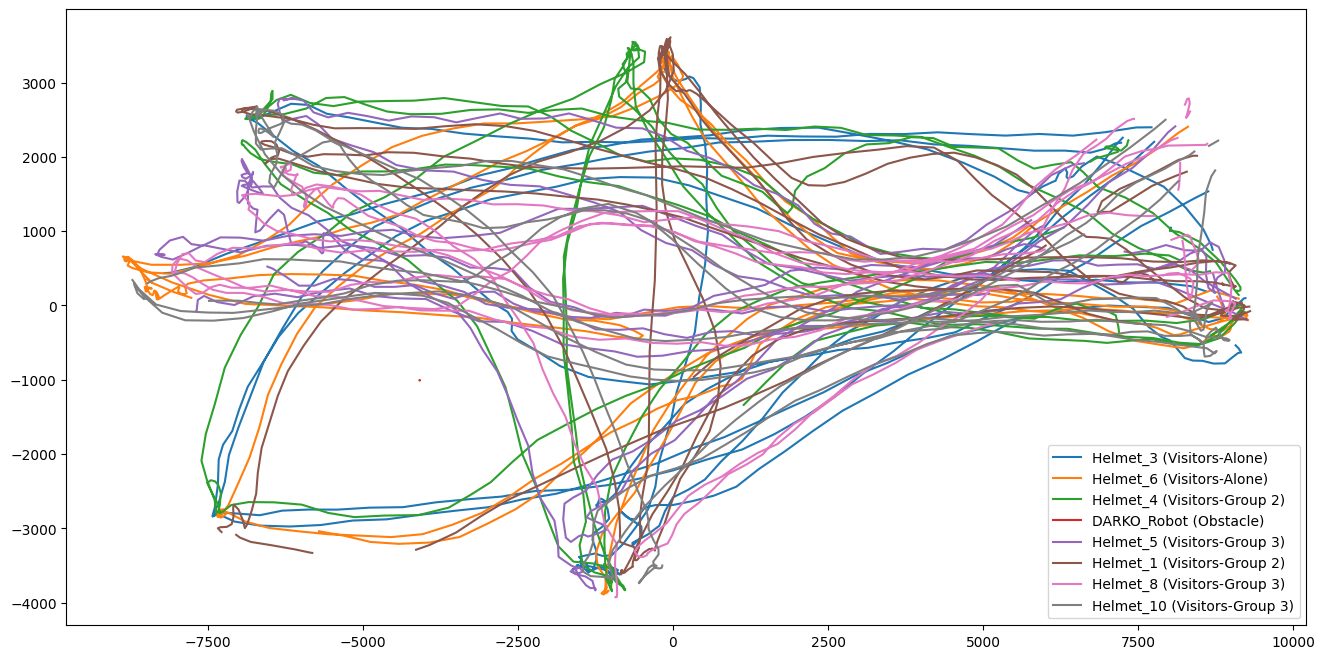

In [10]:
visualize_scenario(pp_best_markers, roles)

In [11]:
pp_restored = TrajectoriesReprocessor.reprocessing(
    restored_markers, 
    max_nans_interpolate=100, # max  1s interpolation
    resampling_rule="400ms",
    average_window="800ms",
)  

2023-11-02 14:11:42,970 - thor_magni_tools.preprocessing.reprocess - DEBUG - resampling applied! (reprocess.py:101)
2023-11-02 14:11:42,970 - thor_magni_tools.preprocessing.reprocess - DEBUG - resampling applied! (reprocess.py:101)
2023-11-02 14:11:42,973 - thor_magni_tools.preprocessing.reprocess - DEBUG - average window applied! (reprocess.py:108)
2023-11-02 14:11:42,973 - thor_magni_tools.preprocessing.reprocess - DEBUG - average window applied! (reprocess.py:108)
2023-11-02 14:11:43,004 - thor_magni_tools.preprocessing.reprocess - DEBUG - resampling applied! (reprocess.py:101)
2023-11-02 14:11:43,004 - thor_magni_tools.preprocessing.reprocess - DEBUG - resampling applied! (reprocess.py:101)
2023-11-02 14:11:43,007 - thor_magni_tools.preprocessing.reprocess - DEBUG - average window applied! (reprocess.py:108)
2023-11-02 14:11:43,007 - thor_magni_tools.preprocessing.reprocess - DEBUG - average window applied! (reprocess.py:108)
2023-11-02 14:11:43,038 - thor_magni_tools.preprocessing

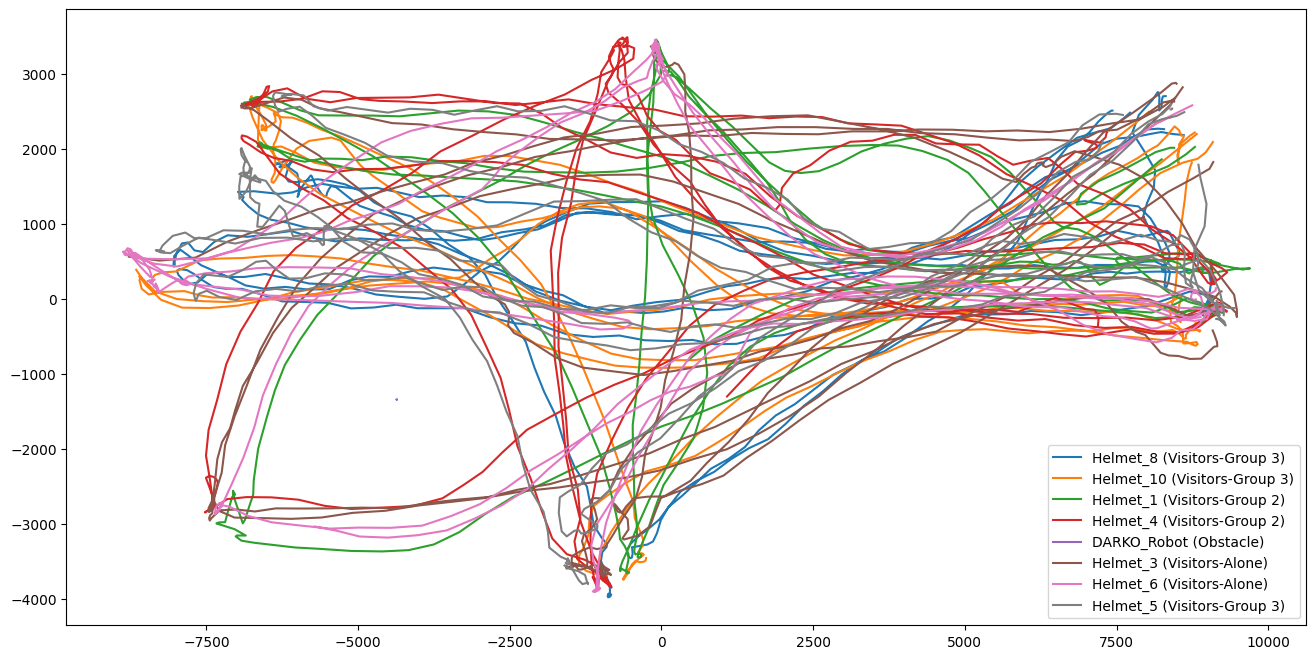

In [12]:
visualize_scenario(pp_restored, roles)

# Animation (take some time depedning on the number of frames)

In [9]:
cmap = get_cmap("tab20")
colors_agent = {
    body_name: cmap.colors[i] for i, body_name in enumerate(traj_metadata.keys())
}

In [10]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.set_ylabel("Y/mm", fontsize=29)
ax.set_xlabel("X/mm", fontsize=29)

camera = Camera(fig)

for frame in pp_restored.frame_id.iloc[:2000]:
    frame_data = pp_restored[pp_restored["frame_id"] == frame]
    agents_frame = frame_data.ag_id.unique()

    for agent in agents_frame:
        agent_data = frame_data[frame_data["ag_id"] == agent]
        agent_role = agent_data["data_label"].iloc[0]
        if not agent_data["x"].isna().all():
            plt.scatter(
                agent_data["x"],
                agent_data["y"],
                c=np.array([colors_agent[agent]]),
                s=70,
            )
            plt.text(
                agent_data["x"]-25,
                agent_data["y"]-50,
                agent.split("_")[-1],
                size="small",
                color="black",
                weight="semibold",
            )
    camera.snap()

# Stop the static plot from displaying
plt.close()

In [11]:
anim = camera.animate(interval = 10, repeat = True, repeat_delay = 500)
HTML(anim.to_html5_video())